Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Wrangle ML datasets 
- Explore tabular data for supervised machine learning
- Join relational data for supervised machine learning

# Explore tabular data for supervised machine learning 🍌

Wrangling your dataset is often the most challenging and time-consuming part of the modeling process.

In today's lesson, we’ll work with a dataset of [3 Million Instacart Orders, Open Sourced](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)!

Let’s get set up:

In [0]:
# Download data
import requests

def download(url):
    filename = url.split('/')[-1]
    print(f'Downloading {url}')
    r = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(r.content)
    print(f'Downloaded {filename}')

download('https://s3.amazonaws.com/instacart-datasets/instacart_online_grocery_shopping_2017_05_01.tar.gz')

Downloaded instacart_online_grocery_shopping_2017_05_01.tar.gz


In [0]:
# Uncompress data
import tarfile
tarfile.open('instacart_online_grocery_shopping_2017_05_01.tar.gz').extractall()

In [0]:
# Change directory to where the data was uncompressed
%cd instacart_2017_05_01

/content/instacart_2017_05_01


In [0]:
# Print the csv filenames
from glob import glob

for filename in glob('*.csv'):
    print(filename)

products.csv
order_products__prior.csv
departments.csv
orders.csv
aisles.csv
order_products__train.csv


In [0]:
# For each csv file, look at its shape & head
import pandas as pd
from IPython.display import display

def preview():
  for filename in glob('*.csv'):
    df = pd.read_csv(filename)
    print(filename)
    print(f'Shape: {df.shape}')
    display(df.head())

preview()

products.csv
Shape: (49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


order_products__prior.csv
Shape: (32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


departments.csv
Shape: (21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


orders.csv
Shape: (3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


aisles.csv
Shape: (134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


order_products__train.csv
Shape: (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


### The original task was complex ...

[The Kaggle competition said,](https://www.kaggle.com/c/instacart-market-basket-analysis/data):

> The dataset for this competition is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order.

> orders.csv: This file tells to which set (prior, train, test) an order belongs. You are predicting reordered items only for the test set orders.

Each row in the submission is an order_id from the test set, followed by product_id(s) predicted to be reordered.

> sample_submission.csv: 
```
order_id,products
17,39276 29259
34,39276 29259
137,39276 29259
182,39276 29259
257,39276 29259
```

### ... but we can simplify!

Simplify the question, from "Which products will be reordered?" (Multi-class, [multi-label](https://en.wikipedia.org/wiki/Multi-label_classification) classification) to **"Will customers reorder this one product?"** (Binary classification)

Which product? How about **the most frequently ordered product?**

### Questions:

- What is the most frequently ordered product?
- How often is this product included in a customer's next order?
- Which customers have ordered this product before?
- How can we get a subset of data, just for these customers?
- What features can we engineer? We want to predict, will these customers reorder this product on their next order?

## Follow Along

### What was the most frequently ordered product?

In [0]:
order_products__train = pd.read_csv('order_products__train.csv')
order_products__train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [0]:
order_products__train['product_id'].value_counts()

24852    18726
13176    15480
21137    10894
21903     9784
47626     8135
         ...  
44256        1
2764         1
4815         1
43736        1
46835        1
Name: product_id, Length: 39123, dtype: int64

In [0]:
# How many times each products appeared in different orders
order_products__train.groupby('product_id')['order_id'].count().sort_values(ascending=True)

product_id
24836        1
8005         1
29566        1
8001         1
29560        1
         ...  
47626     8135
21903     9784
21137    10894
13176    15480
24852    18726
Name: order_id, Length: 39123, dtype: int64

In [0]:
products = pd.read_csv('products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [0]:
train = pd.merge(order_products__train, products, left_on='product_id', right_on='product_id')
train

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1,49302,1,1,Bulgarian Yogurt,120,16
1,816049,49302,7,1,Bulgarian Yogurt,120,16
2,1242203,49302,1,1,Bulgarian Yogurt,120,16
3,1383349,49302,11,1,Bulgarian Yogurt,120,16
4,1787378,49302,8,0,Bulgarian Yogurt,120,16
...,...,...,...,...,...,...,...
1384612,3420011,1528,12,0,Sprinkles Decors,97,13
1384613,3420084,47935,20,0,Classic Original Lip Balm SPF 12,73,11
1384614,3420084,9491,21,0,Goats Milk & Chai Soap,25,11
1384615,3420088,16380,12,0,Stevia Sweetener,97,13


In [0]:
train['product_name'].value_counts()

Banana                                     18726
Bag of Organic Bananas                     15480
Organic Strawberries                       10894
Organic Baby Spinach                        9784
Large Lemon                                 8135
                                           ...  
Alaffia Conditioner Everday Shea               1
Stool Softener Liquid Gels                     1
Hazelnut Light Roast K-Cup Packs Coffee        1
Organic Marshmallow Root                       1
Cheese Buns                                    1
Name: product_name, Length: 39123, dtype: int64

### How often are bananas included in a customer's next order?

There are [three sets of data](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b):

> "prior": orders prior to that users most recent order (3.2m orders)  
"train": training data supplied to participants (131k orders)  
"test": test data reserved for machine learning competitions (75k orders)

Customers' next orders are in the "train" and "test" sets. (The "prior" set has the orders prior to the most recent orders.)

We can't use the "test" set here, because we don't have its labels (only Kaggle & Instacart have them), so we don't know what products were bought in the "test" set orders.

So, we'll use the "train" set. It currently has one row per product_id and multiple rows per order_id.

But we don't want that. Instead we want one row per order_id, with a binary column: "Did the order include bananas?"

Let's wrangle!

In [0]:
train['bananas'] = train['product_name'] == 'Banana'
train.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,bananas
0,1,49302,1,1,Bulgarian Yogurt,120,16,False
1,816049,49302,7,1,Bulgarian Yogurt,120,16,False
2,1242203,49302,1,1,Bulgarian Yogurt,120,16,False
3,1383349,49302,11,1,Bulgarian Yogurt,120,16,False
4,1787378,49302,8,0,Bulgarian Yogurt,120,16,False


In [0]:
# About 1.4% of ordered products are bananas
train['bananas'].value_counts(normalize=True)

False    0.986476
True     0.013524
Name: bananas, dtype: float64

In [0]:
train.shape

(1384617, 8)

In [0]:
train

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,bananas
0,1,49302,1,1,Bulgarian Yogurt,120,16,False
1,816049,49302,7,1,Bulgarian Yogurt,120,16,False
2,1242203,49302,1,1,Bulgarian Yogurt,120,16,False
3,1383349,49302,11,1,Bulgarian Yogurt,120,16,False
4,1787378,49302,8,0,Bulgarian Yogurt,120,16,False
...,...,...,...,...,...,...,...,...
1384612,3420011,1528,12,0,Sprinkles Decors,97,13,False
1384613,3420084,47935,20,0,Classic Original Lip Balm SPF 12,73,11,False
1384614,3420084,9491,21,0,Goats Milk & Chai Soap,25,11,False
1384615,3420088,16380,12,0,Stevia Sweetener,97,13,False


In [0]:
train_wrangled = train.groupby('order_id')['bananas'].any().reset_index()
train_wrangled.head()

,order_id,bananas
0,1,False
1,36,False
2,38,False
3,96,False
4,98,False


In [0]:
train_wrangled.shape

(131209, 2)

In [0]:

train_wrangled['bananas'].value_counts(normalize=True)

False    0.857281
True     0.142719
Name: bananas, dtype: float64

# Join relational data for supervised machine learning

## Overview
Often, you’ll need to join data from multiple relational tables before you’re ready to fit your models.

### Which customers have ordered this product before?

- Customers are identified by `user_id`
- Products are identified by `product_id`

Do we have a table with both these id's? (If not, how can we combine this information?)

- `order.csv` has `user_id` and `order_id`
- `order_products_*.csv` have `order_id` and `product_id`

In [0]:
train.shape

(1384617, 8)

In [0]:
# which orders included bananas
train[train['bananas']==True]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,bananas
129688,226,24852,2,0,Banana,24,4,True
129689,473,24852,2,0,Banana,24,4,True
129690,878,24852,2,1,Banana,24,4,True
129691,1042,24852,1,1,Banana,24,4,True
129692,1139,24852,1,1,Banana,24,4,True
...,...,...,...,...,...,...,...,...
148409,3419531,24852,2,1,Banana,24,4,True
148410,3419542,24852,6,0,Banana,24,4,True
148411,3419629,24852,5,1,Banana,24,4,True
148412,3420088,24852,9,1,Banana,24,4,True


In [0]:
banana_order_id = train[train['bananas']==True]['order_id']
banana_order_id

129688        226
129689        473
129690        878
129691       1042
129692       1139
           ...   
148409    3419531
148410    3419542
148411    3419629
148412    3420088
148413    3420996
Name: order_id, Length: 18726, dtype: int64

In [0]:
orders = pd.read_csv('orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [0]:
orders['order_id'].isin(banana_order_id)

0          False
1          False
2          False
3          False
4          False
           ...  
3421078    False
3421079    False
3421080    False
3421081    False
3421082     True
Name: order_id, Length: 3421083, dtype: bool

In [0]:
banana_orders = orders[orders['order_id'].isin(banana_order_id)]
banana_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
25,1492625,2,train,15,1,11,30.0
485,698604,34,train,6,4,13,30.0
623,1864787,43,train,12,5,11,26.0
652,1947848,46,train,20,4,20,11.0
881,13318,56,train,13,1,9,6.0


In [0]:
banana_user_id = banana_orders['user_id'].unique()
banana_user_id

array([     2,     34,     43, ..., 206196, 206205, 206209])

In [0]:
banana_user_id.shape

(18726,)

## Follow Along

### How can we get a subset of data, just for these customers?

We want *all* the orders from customers who have *ever* bought bananas.

(And *none* of the orders from customers who have *never* bought bananas.)

In [0]:
orders.shape

(3421083, 7)

In [0]:
orders['user_id'].isin(banana_user_id)

0          False
1          False
2          False
3          False
4          False
           ...  
3421078     True
3421079     True
3421080     True
3421081     True
3421082     True
Name: user_id, Length: 3421083, dtype: bool

In [0]:
orders_subset = orders[orders['user_id'].isin(banana_user_id)]
orders_subset

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
11,2168274,2,prior,1,2,11,NaN
12,1501582,2,prior,2,5,10,10.0
13,1901567,2,prior,3,1,10,3.0
14,738281,2,prior,4,2,10,8.0
15,1673511,2,prior,5,3,11,8.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


### What features can we engineer? We want to predict, will these customers reorder bananas on their next order?

- Days since last banana order
- Time of day
- Have they ordered bananase before? If so, how many times?
- Frequency of ordering fruits and veggies
- Is majority of items in the order fruit?
- Size of an order


In [0]:
USER_ID = 2
orders_subset[orders_subset['user_id']==USER_ID]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
11,2168274,2,prior,1,2,11,NaN
12,1501582,2,prior,2,5,10,10.0
13,1901567,2,prior,3,1,10,3.0
14,738281,2,prior,4,2,10,8.0
15,1673511,2,prior,5,3,11,8.0
16,1199898,2,prior,6,2,9,13.0
17,3194192,2,prior,7,2,12,14.0
18,788338,2,prior,8,1,15,27.0
19,1718559,2,prior,9,2,9,8.0
20,1447487,2,prior,10,1,11,6.0


# Let's merge several tables together in one line

In [0]:
merged_df = orders.merge(order_products__train).merge(products)
merged_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1187899,1,train,11,4,8,14.0,196,1,1,Soda,77,7
1,2757217,67,train,25,0,11,5.0,196,1,1,Soda,77,7
2,632715,676,train,12,0,13,26.0,196,2,1,Soda,77,7
3,1167274,760,train,5,4,10,8.0,196,2,1,Soda,77,7
4,3347074,804,train,16,3,21,5.0,196,4,0,Soda,77,7


In [0]:
merged_df.shape

(1384617, 13)

In [0]:
merged_df_bananas = merged_df[merged_df['product_name'] == 'Banana']
merged_df_bananas

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
15942,1492625,2,train,15,1,11,30.0,24852,8,1,Banana,24,4
15943,698604,34,train,6,4,13,30.0,24852,2,0,Banana,24,4
15944,1864787,43,train,12,5,11,26.0,24852,1,1,Banana,24,4
15945,1947848,46,train,20,4,20,11.0,24852,1,1,Banana,24,4
15946,13318,56,train,13,1,9,6.0,24852,1,1,Banana,24,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34663,681092,206181,train,15,1,13,30.0,24852,1,1,Banana,24,4
34664,2530125,206191,train,6,0,9,30.0,24852,12,1,Banana,24,4
34665,3383615,206196,train,5,0,15,30.0,24852,2,1,Banana,24,4
34666,1716008,206205,train,4,1,16,10.0,24852,5,0,Banana,24,4


In [0]:
merged_df_bananas['user_id']

15942         2
15943        34
15944        43
15945        46
15946        56
          ...  
34663    206181
34664    206191
34665    206196
34666    206205
34667    206209
Name: user_id, Length: 18726, dtype: int64

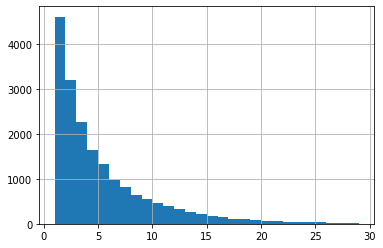

In [0]:
# At what point do people add bananas to their shopping cart?
merged_df_bananas['add_to_cart_order'].hist(bins=range(1, 30))

## Challenge

**Continue to clean and explore your data.** Can you **engineer features** to help predict your target? For the evaluation metric you chose, what score would you get just by guessing? Can you **make a fast, first model** that beats guessing?

We recommend that you use your portfolio project dataset for all assignments this sprint. But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset today. Follow the instructions in the assignment notebook. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!